In [2]:
import numpy as np
import pandas as pd
import json
from datetime import datetime
import re

# Install VADER
[vaderSentiment](https://github.com/cjhutto/vaderSentiment)

`>pip install vaderSentiment`

# Install spaCy
[spaCy](https://spacy.io/usage/)

`>pip install -U spacy`

`>python -m spacy download en`

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from spacy import displacy

# Trump approval rating
Trump approval rating data gathered from [FiveThirtyEight](https://github.com/fivethirtyeight/data/tree/master/trump-approval-ratings), under the [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).

In [4]:
df = pd.read_csv('https://projects.fivethirtyeight.com/trump-approval-data/approval_topline.csv')
#change `modeldate` data type to datetime.date
for index,row in df.iterrows():
    df.at[index,'modeldate'] = datetime.strptime(row['modeldate'], '%m/%d/%Y').date()
df.head()

,president,subgroup,modeldate,approve_estimate,approve_hi,approve_lo,disapprove_estimate,disapprove_hi,disapprove_lo,timestamp
0,Donald Trump,Voters,2018-05-04,43.67850,48.15509,39.20191,51.79247,55.71738,47.86755,09:35:55 4 May 2018
1,Donald Trump,Adults,2018-05-04,40.63160,44.33444,36.92875,52.52063,56.79234,48.24892,09:35:43 4 May 2018
2,Donald Trump,All polls,2018-05-04,41.41713,46.11049,36.72378,52.48483,56.55785,48.41181,09:35:32 4 May 2018
3,Donald Trump,Voters,2018-05-03,43.54569,47.88125,39.21012,51.86760,55.74757,47.98762,14:54:54 3 May 2018
4,Donald Trump,Adults,2018-05-03,40.63160,44.33444,36.92875,52.52063,56.79234,48.24892,14:54:42 3 May 2018


We want the daily approval estimate from all polls.

In [5]:
approval_estimates = df[df['subgroup'] == 'All polls'][['modeldate','approve_estimate','disapprove_estimate']]
approval_estimates.head(30)

,modeldate,approve_estimate,disapprove_estimate
2,2018-05-04,41.41713,52.48483
5,2018-05-03,41.31839,52.53112
8,2018-05-02,41.15172,52.91795
11,2018-05-01,41.21312,52.94305
14,2018-04-30,40.64146,53.66854
15,2018-04-29,40.37253,53.95501
20,2018-04-28,40.37253,53.95501
23,2018-04-27,40.59867,53.73807
26,2018-04-26,40.59169,53.74832
29,2018-04-25,40.51619,53.66458


Get today's approval rating.

In [6]:
current_approval = approval_estimates[approval_estimates['modeldate'] == datetime.now().date()]['approve_estimate'].values[0]
current_disapproval = approval_estimates[approval_estimates['modeldate'] == datetime.now().date()]['disapprove_estimate'].values[0]

print(current_approval)

41.41713


Define a function that runs sentiment analysis and named entity recognition on given text.

In [7]:
analyzer = SentimentIntensityAnalyzer()
nlp = spacy.load('en')

def process_tweet(text):
    vs = analyzer.polarity_scores(text)
    #print('neg: ' + str(vs['neg']))
    #print('neu: ' + str(vs['neu']))
    #print('pos: ' + str(vs['pos']))
    #print('compound: ' + str(vs['compound']))
    doc = nlp(text)
    #displacy.render(doc, style='ent', jupyter=True)
    return vs, doc.ents

# Uploading Trump's tweets to Amazon S3
We can get Trump's tweets using either the Twitter Streaming API or REST API. A comparison can be found [here](https://stackoverflow.com/questions/5960128/streaming-api-vs-rest-api).

[tweepy](https://github.com/tweepy/tweepy) is a Python wrapper of the Twitter API.

`>pip install tweepy`

[Boto3](https://github.com/boto/boto3) is the AWS SDK for Python.

`>pip install boto3`

Create a [Twitter App](https://apps.twitter.com/) and navigate to "Keys and Access Tokens."

Store the four application tokens in `application_tokens.py`, along with your AWS access key ID and secret access key.
```
consumer_key = 'your_consumer_key'
consumer_secret = 'your_consumer_secret'
access_token = 'your_access_token_key'
access_token_secret = 'your_access_token_secret'
aws_access_key_id = 'your_aws_access_key_id'
aws_secret_access_key = 'your_aws_secret_access_key'
```

In [8]:
import tweepy
import boto3
from application_tokens import *

Set up tweepy.

In [9]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

try:
    redirect_url = auth.get_authorization_url()
except tweepy.TweepError:
    print('Error! Failed to get request token.')

api = tweepy.API(auth)

Set up boto3.

[Creating the connection and creating a bucket](http://boto3.readthedocs.io/en/latest/guide/migrations3.html#creating-the-connection)

In [10]:
#name of your bucket
bucket_name = 'trump-snapshot'

#create the connection
s3 = boto3.resource('s3',
                      aws_access_key_id=aws_access_key_id,
                      aws_secret_access_key=aws_secret_access_key)

#create a bucket
s3.create_bucket(Bucket=bucket_name)

s3.Bucket(name='trump-snapshot')

Define a function to update the S3 database with Trump's most recent tweets.

[Storing data](http://boto3.readthedocs.io/en/latest/guide/migrations3.html#storing-data)

In [11]:
def update_database(filename):
    s3.Object(bucket_name, filename).put(Body=open(filename, 'rb'))

Define a function to get a user's most recent tweets.

In [12]:
def get_tweets(screen_name, count):
    new_tweets = api.user_timeline(screen_name=screen_name,count=count, tweet_mode='extended')
    new_tweets = [{"created_at":i.created_at.strftime("%Y-%m-%d %H:%M:%S"),"id": i.id,'retweet_count':i.retweet_count,'favorite_count':i.favorite_count,'text':i.full_text} for i in new_tweets]
    return new_tweets

Check Trump's last 200 tweets and save them to `new_tweets.json`. Keep track of the named entities mentioned.

In [13]:
ents = {}
counts = {}
screen_name = 'realDonaldTrump'

for i in get_tweets(screen_name, 200):
    vs, tweet_ents = process_tweet(i['text'])
    #accumulate named entities
    for ent in tweet_ents:
        if ent.text in counts:
            counts[ent.text] += 1
        else:
            ents[ent.text] = ent.label_
            counts[ent.text] = 1

with open('new_tweets.json','wb') as f:
    f.write(json.dumps(get_tweets(screen_name, 200)).encode('utf-8'))

Upload the tweets to the S3 database.

In [174]:
#update_database('new_tweets.json')

# Generating visuals from the tweets
[word_cloud](https://github.com/amueller/word_cloud)

`>pip install wordcloud`

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.font_manager as fm
from matplotlib import rcParams
import seaborn as sns
from textwrap import wrap
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

Load tweets from the past day and retrieve the tweet text, entities, and sentiment.

In [15]:
from collections import Counter

ents_dict = {}
counts_dict = {}
retweet_count = 0
favorite_count = 0

full_text = ''
pos_text = ''
neg_text = ''
neu_text = ''
sentiment = []
entities = []
tweet_count = 0
avg_sentiment = 0
# collection of words and their cumulative sentiment
counter = Counter()
pos_count = Counter()
neg_count = Counter()
neu_count = Counter()
pos_sent = Counter()
neg_sent = Counter()
neu_sent = Counter()

wordcloud = WordCloud(width=512,height=412,font_path='Libre_Franklin/LibreFranklin-SemiBold.ttf',stopwords=STOPWORDS,background_color='white',max_font_size=128).generate('test')

for tweet in json.load(open('new_tweets.json')):
    if (tweet['created_at'][:10] == str(datetime.now().date())):
        tweet_count += 1
        retweet_count += tweet['retweet_count']
        favorite_count += tweet['favorite_count']
        re.sub('[!@#$]', '', tweet['text'])
        full_text += re.sub('http\S*', '', tweet['text'])
        
        vs, daily_ents = process_tweet(tweet['text'])
        
        words = WordCloud.process_text(wordcloud, tweet['text'])
        if vs['compound'] > 0:
            pos_text += ' ' + re.sub('http\S*', '', tweet['text'])
            pos_count.update(Counter(words))
            for key in words.keys():
                pos_sent.update(Counter({key:vs['compound']*words[key]}))
        else:
            if vs['compound'] < 0:
                neg_text += re.sub('http\S*', '', tweet['text'])
                neg_count.update(Counter(words))
                for key in words.keys():
                    neg_sent.update(Counter({key:vs['compound']*words[key]}))
            else:
                neu_text += re.sub('http\S*', '', tweet['text'])
                neu_count.update(Counter(words))
                for key in words.keys():
                    neu_sent.update(Counter({key:vs['compound']*words[key]}))
        
        tweet_dict = {}
        for word in words.keys():
            if word in tweet_dict.keys():
                tweet_dict[word] += vs['compound'] * words[word]
            else:
                tweet_dict[word] = vs['compound'] * words[word]
        #update counter with sentiment of this tweet, multiplied by the number of occurrences
        counter.update(Counter(tweet_dict))
        
        #accumulate named entities
        for ent in daily_ents:
            if ent.text in counts_dict:
                counts_dict[ent.text] += 1
            else:
                ents_dict[ent.text] = ent.label_
                counts_dict[ent.text] = 1
        sentiment.append(vs['compound'])
        avg_sentiment += vs['compound']
        entities.append('\n'.join(str(e) for e in daily_ents))
avg_sentiment /= tweet_count

Generate text for tweet text and visualization text.

In [16]:
avg_sent=np.mean(sentiment)
dev_sent=np.std(sentiment)
def sentiment_sentence(mean,std):
    m_word = ["very negative","negative","neutral","positive","very positive"]
    m_word2 = ["overwhelmingly negative", "generally negative", "", "generally positive","overwhelmingly positive"]
    d_word = ["consistently","mixed"]
    score=[2,0]
    
    if mean>.6:
        score[0]=4
    elif mean<-.6:
        score[0]=0
    elif mean>.2:
        score[0]=3
    elif mean<-.2:
        score[0]=1
        
    if std>.5:
        score[1]=1
        
    base="His tweets were "
    
    if score[1]==0:
        base+=(d_word[0]+" "+m_word[score[0]])
    else:
        if score[0]==2:
            base+=d_word[1]
        else:
            base+=(d_word[1]+", but "+m_word2[score[0]])
    return base+"."
print(sentiment_sentence(avg_sent,dev_sent))

His tweets were mixed, but generally negative.


In [17]:
#sentiment word
if (sum(np.sign(sentiment)) > 0):
    sentiment_word = 'positive'
else:
    sentiment_word = 'negative'
    
#entities_list
text = list(ents_dict.keys())
labels = list(ents_dict.values())
data = {'text':text,'label':labels}
df2 = pd.DataFrame(data)
for index,row in df2.iterrows():
    df2.at[index,'count'] = counts[row['text']]
#sort by count
df2 = df2.sort_values(by=['count'], ascending=False)
arr = df2.head()['text'].values
entities_list = ''.join(str(e + ', ') for e in arr[:-1])
entities_list += 'and ' + arr[len(arr)-1] + '.'

#rts over total ratio
count_str = 'Today, @' + screen_name + ' tweeted ' + str(tweet_count) + ' times.'

ratio_str = 'These tweets were retweeted an average of ' + str(int(retweet_count/tweet_count)) + ' times and favorited an average of ' + str(int(favorite_count/tweet_count)) + ' times.'
#sentiment_str = 'Most of his tweets were ' + sentiment_word + '.'
#new version with more detail
sentiment_str = sentiment_sentence(avg_sent,dev_sent)
entities_str = 'He mentioned ' + entities_list
approval_str = 'His approval rating is ' + str(round(current_approval,1)) + '%.'
print(count_str)
print(ratio_str)
print(sentiment_str)
print(entities_str)
print(approval_str)

final_str = count_str + ' ' + sentiment_str + ' ' + entities_str + ' ' + approval_str

Today, @realDonaldTrump tweeted 6 times.
These tweets were retweeted an average of 11553 times and favorited an average of 51302 times.
His tweets were mixed, but generally negative.
He mentioned Congress, today, U.S., Fake News, and Americans.
His approval rating is 41.4%.


## Bar plot of retweets and favorites

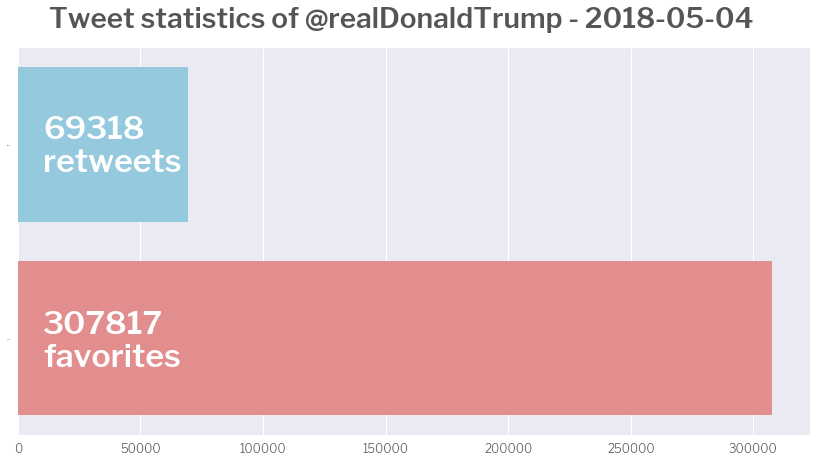

In [295]:
fig = plt.figure(figsize=(14.2, 7.12))
ax = sns.barplot(y=['retweets','favorites'], x=[retweet_count,favorite_count],palette=['skyblue','lightcoral'],orient='h')

tick_prop = fm.FontProperties(fname='Libre_Franklin/LibreFranklin-Light.ttf',size=12)
ax_prop = fm.FontProperties(fname='Libre_Franklin/LibreFranklin-Light.ttf',size=16)
title_prop = fm.FontProperties(fname='Libre_Franklin/LibreFranklin-SemiBold.ttf',size=28)

ax.set_xlabel('', fontproperties=ax_prop, color='#555555')
plt.figtext(.5,.92, 'Tweet statistics of @' + screen_name + ' - ' + str(datetime.now().date()), fontproperties=title_prop, ha='center')

bar_prop = fm.FontProperties(fname='Libre_Franklin/LibreFranklin-SemiBold.ttf',size=32)

plt.figtext(.15,.64, str(retweet_count) + '\nretweets', fontproperties=bar_prop,color='white')
plt.figtext(.15,.26, str(favorite_count) + '\nfavorites', fontproperties=bar_prop,color='white')

plt.xticks(fontproperties=tick_prop,color='#555555')
plt.yticks(size=0)
plt.savefig('stats_plt.png')

stats_transparent = Image.new('RGBA', (1024, 512))
stats_img = Image.open('stats_plt.png')

new_box = (2,0, h1.size[0]+2,h1.size[1])
stats_transparent.paste(stats_img,new_box)
stats_transparent.save('stats_plt.png')

## Violin plot of sentiment

[Display sections of a matplotlib violinplot in different colours (colors) either side of a threshold value](https://stackoverflow.com/questions/42330147/display-sections-of-a-matplotlib-violinplot-in-different-colours-colors-either)

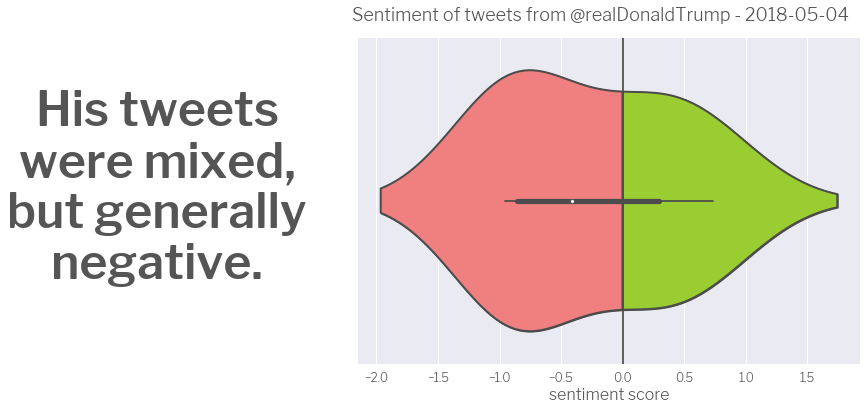

In [313]:
prop = fm.FontProperties(fname='Libre_Franklin/LibreFranklin-SemiBold.ttf',size=48)

rcParams['text.color'] = '#555555'
rcParams['axes.titlesize'] = 'large'
rcParams['axes.titleweight'] = 'bold'

fig, ax = plt.subplots(figsize=(9,6))

# sep is the point where the separation should occur
sep = 0
plt.axvline(x=sep, color='#4c4c4c')

sns.violinplot(ax=ax, x=sentiment)

#obtain path of violin surrounding
path = ax.collections[0].get_paths()[0]
path_neg = path.clip_to_bbox([-2,-2,0,1], inside=True)
patch_neg = matplotlib.patches.PathPatch(path_neg, facecolor='lightcoral', lw=2, ec='#4c4c4c')
path_pos = path.clip_to_bbox([0,-1,2,2], inside=True)
patch_pos = matplotlib.patches.PathPatch(path_pos, facecolor='yellowgreen', lw=2, ec='#4c4c4c')

ax.add_patch(patch_neg)
ax.add_patch(patch_pos)

ax.set_xlabel('sentiment score', fontproperties=ax_prop, color='#555555')
ax.set_title("\n".join(wrap(sentiment_str,14)),fontproperties=prop,x=-0.4,y=0.2, color='#555555')
plt.figtext(.5,.92, 'Sentiment of tweets from @' + screen_name + ' - ' + str(datetime.now().date()), fontproperties=ax_prop, fontsize=18, ha='center')

plt.xticks(fontproperties=tick_prop,color='#555555')
plt.savefig('sentiment_plt.png', bbox_inches='tight')

## Word cloud

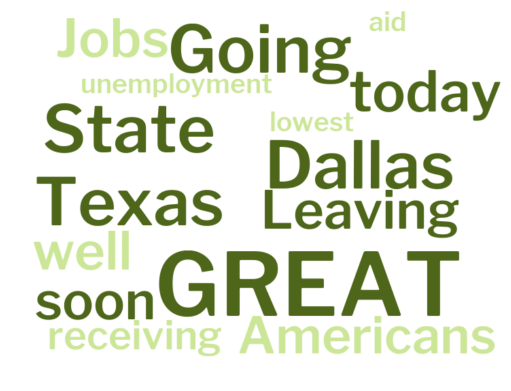

In [202]:
def clamp(color):
    return min(255,max(0,color))

max_color = 188
pos_r = 154
pos_g = 205
pos_b = 50
def pos_func(word, font_size, position, orientation,
                    **kwargs):
    max_sent = max(pos_sent.values())
    min_sent = min(pos_sent.values())
    grad = 255-(((pos_sent[word]-min_sent)/(max_sent-min_sent))*255)
    return '#%02x%02x%02x' % (clamp(int((pos_r+grad)/2)), clamp(int((pos_g+grad)/2)), clamp(int((pos_b+grad)/2)))

custom_stopwords = {screen_name,'RT','will'}
wordcloud = WordCloud(width=696,height=524,font_path='Libre_Franklin/LibreFranklin-SemiBold.ttf',stopwords=STOPWORDS.union(custom_stopwords),background_color='white',max_font_size=128).generate(pos_text)
plt.figure(figsize=(8.7,6.55))
plt.axis("off")
plt.imshow(wordcloud.recolor(color_func=pos_func), interpolation="bilinear")
fig = plt.gcf()
wordcloudname = 'wordcloud.png'
fig.savefig(wordcloudname, bbox_inches='tight')

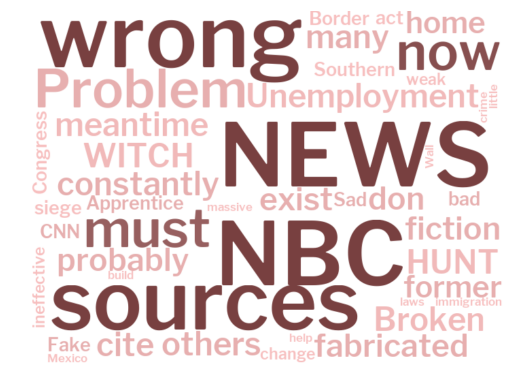

In [203]:
neg_r = 240
neg_g = 128
neg_b = 128
def neg_func(word, font_size, position, orientation,
                    **kwargs):
    max_sent = -(min(neg_sent.values()))
    min_sent = -(max(neg_sent.values()))
    grad = 255-(((-neg_sent[word]-min_sent)/(max_sent-min_sent))*255)
    return '#%02x%02x%02x' % (clamp(int((neg_r+grad)/2)), clamp(int((neg_g+grad)/2)), clamp(int((neg_b+grad)/2)))

plt.figure(figsize=(8.7,6.55))
plt.axis("off")
wordcloud_neg = WordCloud(width=696,height=524,font_path='Libre_Franklin/LibreFranklin-SemiBold.ttf',stopwords=STOPWORDS.union(custom_stopwords),background_color='white',max_font_size=128).generate(neg_text)
plt.imshow(wordcloud_neg.recolor(color_func=neg_func), interpolation="bilinear")
fig = plt.gcf()
wordcloudname = 'wordcloud_neg.png'
fig.savefig(wordcloudname, bbox_inches='tight')

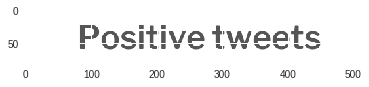

In [204]:
from PIL import ImageDraw, ImageFont

pos_cloud = Image.open('wordcloud.png')
pos_x = pos_cloud.size[0]
pos_y = pos_cloud.size[1]
neg_cloud = Image.open('wordcloud_neg.png')
neg_x = neg_cloud.size[0]
neg_y = neg_cloud.size[1]

img = Image.new('RGB', (pos_x, 80), color = (255, 255, 255))

fnt = ImageFont.truetype('Libre_Franklin/LibreFranklin-SemiBold.ttf', 50)
d = ImageDraw.Draw(img)
d.text((10,10), "       Positive tweets", font=fnt, fill='#555555')
plt.imshow(img)
img.save('positive_tweets_text.png')

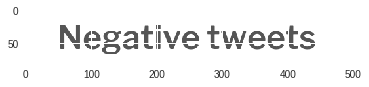

In [205]:
img2 = Image.new('RGB', (neg_x, 80), color = (255, 255, 255))
d2 = ImageDraw.Draw(img2)
d2.text((10,10), "    Negative tweets", font=fnt, fill='#555555')
plt.imshow(img2)
img2.save('negative_tweets_text.png')

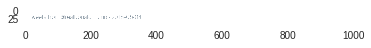

In [206]:
fnt_small = ImageFont.truetype('Libre_Franklin/LibreFranklin-Thin.ttf', 16)
img3 = Image.new('RGB', (pos_x + neg_x, 41), color = (255, 255, 255))
d3 = ImageDraw.Draw(img3)
d3.text((10,10), "Tweets from @" + screen_name + ' - ' + str(datetime.now().date()), font=fnt_small, fill='#657786')
plt.imshow(img3)
img3.save('source.png')

We want to combine the images for the final graphic.

(511, 391)
(1022, 512)


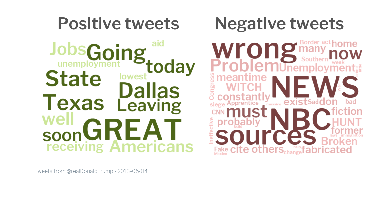

In [207]:
h1 = Image.open('positive_tweets_text.png')
h1_x = h1.size[0]
h1_y = h1.size[1]
print(pos_cloud.size)
h2 = Image.open('negative_tweets_text.png')
h2_x = h2.size[0]
h2_y = h2.size[1]
source = Image.open('source.png')
source_x = source.size[0]
source_y = source.size[1]

x = h1_x + h2_x
y = h1_y + pos_y + source_y

#add h2
crop = (0, 0, x, h1_y)
new_box = (h1_x, 0, x, h1_y)
h1 = h1.crop(crop)
#paste second header
h1.paste(h2,new_box)

#add images
crop = (0, 0, x, y)
new_box = (0, h1_y, pos_x, h1_y + pos_y)
h1 = h1.crop(crop)
h1.paste(pos_cloud,new_box)

new_box = (pos_x, h2_y, x, h1_y + pos_y)
h1.paste(neg_cloud,new_box)

#add source
new_box = (0, h2_y + pos_y, x, y)
h1.paste(source,new_box)

plt.axis('off')
h1.save('wordcloud_plt.png')
plt.imshow(h1)
print(h1.size)

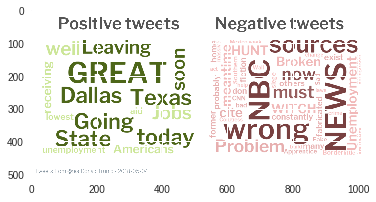

In [289]:
transparent1 = Image.new('RGBA', (1024, 512))
x_margin = int((1024-h1.size[0])/2)
y_margin = int((512-h1.size[1])/2)
#new_box = (x_margin,y_margin, 1024-x_margin,512-y_margin)
new_box = (2,0, h1.size[0]+2,h1.size[1])
transparent1.paste(h1,new_box)
plt.imshow(transparent)
transparent1.save('wordcloud_plt.png')

#transparent2 = Image.new('RGBA', (1024, 512))
#transparent2.paste(h1,new_box)
#transparent3 = Image.new('RGBA', (1024, 512))
#transparent3.paste(h1,new_box)
#transparent4 = Image.new('RGBA', (1024, 512))
#transparent4.paste(h1,new_box)

#transparent1.save('stats_plt.png')
#transparent1.save('sentiment_plt.png')
#transparent1.save('approval_plt.png')

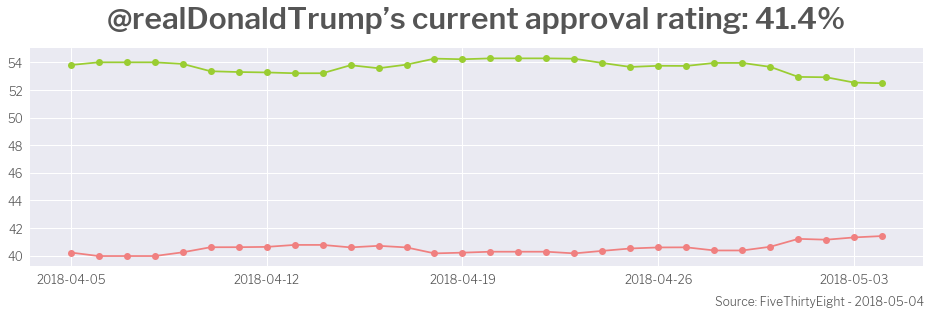

In [200]:
rcParams['axes.titlepad'] = 20 

num_days = 30
data = approval_estimates.head(num_days)
plt.figure(figsize=(16,4))
plt.plot_date(data.modeldate, data.approve_estimate,ls='solid',c='lightcoral')
plt.plot_date(data.modeldate, data.disapprove_estimate,ls='solid',c='yellowgreen')
plt.title('@' + screen_name + "’s current approval rating: " + str(round(current_approval,1)) + '%', fontproperties=prop,color='#555555')
plt.figtext(.81,-.01, 'Source: FiveThirtyEight - ' + str(datetime.now().date()), fontproperties=ax_prop, fontsize=12, ha='center')
plt.xticks(fontproperties=tick_prop,color='#555555')
plt.yticks(fontproperties=tick_prop,color='#555555')
plt.savefig('approval_plt.png', bbox_inches='tight')

In [314]:
# upload images and get media_ids
filenames = ['stats_plt.png', 'sentiment_plt.png','wordcloud_plt.png', 'approval_plt.png']
media_ids = []
for filename in filenames:
    res = api.media_upload(filename)
    media_ids.append(res.media_id)

# tweet with multiple images
api.update_status(status=final_str, media_ids=media_ids)

Status(_api=<tweepy.api.API object at 0x7f76b9354828>, _json={'created_at': 'Fri May 04 18:45:52 +0000 2018', 'id': 992475414143660037, 'id_str': '992475414143660037', 'text': 'Today, @realDonaldTrump tweeted 6 times. His tweets were mixed, but generally negative. He mentioned Congress, toda… https://t.co/nXADjEF0Qb', 'truncated': True, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'realDonaldTrump', 'name': 'Donald J. Trump', 'id': 25073877, 'id_str': '25073877', 'indices': [7, 23]}], 'urls': [{'url': 'https://t.co/nXADjEF0Qb', 'expanded_url': 'https://twitter.com/i/web/status/992475414143660037', 'display_url': 'twitter.com/i/web/status/9…', 'indices': [117, 140]}]}, 'source': '<a href="https://twitter.com/trump_snapshot" rel="nofollow">trump_snapshot</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 991761764936245248, 'i

# Appendix A: old walkthroughs
## Sentiment analysis of Trump's tweets
[Trump tweet analysis by NPR Apps](https://github.com/nprapps/trump-tweet-analysis/blob/master/trump-tweets.ipynb)

[What We Learned About The Mood Of Trump's Tweets](https://www.npr.org/2017/04/30/526106612)

The code below downloads a `.zip` of Trump tweets from an [archive](https://github.com/bpb27/trump_tweet_data_archive) updated every hour.

In [6]:
import requests
import zipfile
import io

response = requests.get('https://github.com/bpb27/trump_tweet_data_archive/raw/master/condensed_2018.json.zip')
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall('data')

Load the JSON data into a DataFrame.

In [160]:
with open('data/condensed_2018.json') as f:
    jsondata = json.load(f)

tweets = pd.read_json('data/condensed_2018.json')
tweets.head()

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text
0,2018-04-13 16:21:16,19473,984828878060335104,NaN,False,5020,Media Studio,"We are bringing back our factories, we are bri..."
1,2018-04-13 12:17:37,83341,984767560494313472,NaN,False,21959,Twitter for iPhone,"....untruthful slime ball who was, as time has..."
2,2018-04-13 12:01:47,72172,984763579210633216,NaN,False,20651,Twitter for iPhone,James Comey is a proven LEAKER &amp; LIAR. Vir...
3,2018-04-13 11:44:51,60824,984759315046322176,NaN,False,14010,Twitter for iPhone,"Tremendous pressure is building, like never be..."
4,2018-04-13 03:15:16,57223,984631073865953280,NaN,False,13076,Twitter for iPhone,Would only join TPP if the deal were substanti...


## Processing the data

For each tweet, run sentiment analysis on the text. Descriptions of the sentiment scores can be found [here](https://github.com/cjhutto/vaderSentiment#about-the-scoring).

In [161]:
analyzer = SentimentIntensityAnalyzer()

for index,row in tweets.iterrows():
    text = row['text']
    vs = analyzer.polarity_scores(text)
    tweets.at[index,'neg'] = vs['neg']
    tweets.at[index,'neu'] = vs['neu']
    tweets.at[index,'pos'] = vs['pos']
    tweets.at[index,'compound'] = vs['compound']
    
tweets.head()

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,neg,neu,pos,compound
0,2018-04-13 16:21:16,19473,984828878060335104,NaN,False,5020,Media Studio,"We are bringing back our factories, we are bri...",0.000,0.856,0.144,0.6360
1,2018-04-13 12:17:37,83341,984767560494313472,NaN,False,21959,Twitter for iPhone,"....untruthful slime ball who was, as time has...",0.164,0.714,0.121,-0.3802
2,2018-04-13 12:01:47,72172,984763579210633216,NaN,False,20651,Twitter for iPhone,James Comey is a proven LEAKER &amp; LIAR. Vir...,0.388,0.612,0.000,-0.9742
3,2018-04-13 11:44:51,60824,984759315046322176,NaN,False,14010,Twitter for iPhone,"Tremendous pressure is building, like never be...",0.160,0.728,0.112,-0.3149
4,2018-04-13 03:15:16,57223,984631073865953280,NaN,False,13076,Twitter for iPhone,Would only join TPP if the deal were substanti...,0.025,0.874,0.101,0.6468


Add daily approval estimates to each tweet.

In [162]:
for index,row in tweets.iterrows():
    date = row['created_at'].date()
    approval = approval_estimates[approval_estimates['modeldate'] == date].iloc[0].loc['approve_estimate']
    tweets.at[index,'approval'] = approval/100.0
tweets.head()

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,neg,neu,pos,compound,approval
0,2018-04-13 16:21:16,19473,984828878060335104,NaN,False,5020,Media Studio,"We are bringing back our factories, we are bri...",0.000,0.856,0.144,0.6360,0.406863
1,2018-04-13 12:17:37,83341,984767560494313472,NaN,False,21959,Twitter for iPhone,"....untruthful slime ball who was, as time has...",0.164,0.714,0.121,-0.3802,0.406863
2,2018-04-13 12:01:47,72172,984763579210633216,NaN,False,20651,Twitter for iPhone,James Comey is a proven LEAKER &amp; LIAR. Vir...,0.388,0.612,0.000,-0.9742,0.406863
3,2018-04-13 11:44:51,60824,984759315046322176,NaN,False,14010,Twitter for iPhone,"Tremendous pressure is building, like never be...",0.160,0.728,0.112,-0.3149,0.406863
4,2018-04-13 03:15:16,57223,984631073865953280,NaN,False,13076,Twitter for iPhone,Would only join TPP if the deal were substanti...,0.025,0.874,0.101,0.6468,0.406863


Plot positive sentiment and approval estimates of Trump's last 100 tweets.

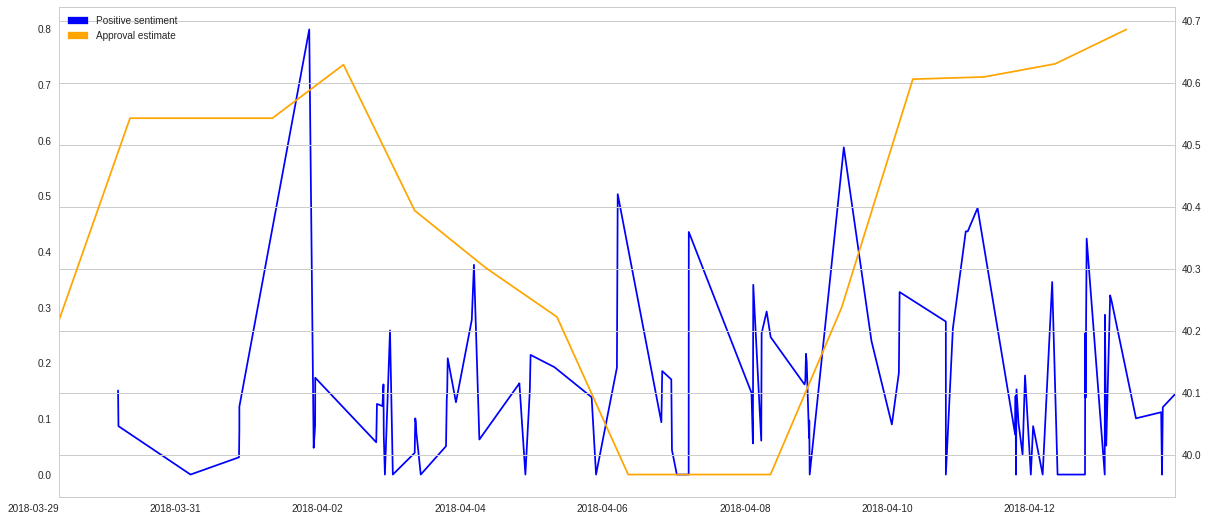

In [163]:
tweets_l00 = tweets[:100]

#positive sentiment of tweets
tweets_l00 = tweets_l00.rename(tweets_l00['created_at'])['pos']
plt.figure()
tweets_l00.plot(figsize=(20,10), color='blue')

#approval estimates
mindate = tweets_l00.index.min().to_pydatetime().date()
approval_estimates = approval_estimates.rename(approval_estimates['modeldate'])
approval_estimates['approve_estimate'].truncate(after=mindate).plot(secondary_y=True, color='orange')

#legend
blue_patch = mpatches.Patch(color='blue', label='Positive sentiment')
orange_patch = mpatches.Patch(color='orange', label='Approval estimate')
plt.legend(handles=[blue_patch,orange_patch])

## Named entity recognition with spaCy
Run [spaCy's entity visualizer](https://spacy.io/usage/visualizers#section-ent) on Trump's last 200 tweets.

In [165]:
nlp = spacy.load('en')

tweets_200 = tweets[:200]
ents = {}
counts = {}

for index,row in tweets_200.iterrows():
    doc = nlp(row['text'])
    #accumulate named entities
    for ent in doc.ents:
        if ent.text in counts:
            counts[ent.text] += 1
        else:
            ents[ent.text] = ent.label_
            counts[ent.text] = 1
    #print `created_at` date
    print(row['created_at'])
    #visualize tweet
    displacy.render(doc, style='ent', jupyter=True)

2018-04-13 16:21:16


2018-04-13 12:17:37


2018-04-13 12:01:47


2018-04-13 11:44:51


2018-04-13 03:15:16


2018-04-12 19:03:57


2018-04-12 18:32:30


2018-04-12 17:13:12


2018-04-12 16:46:15


2018-04-12 16:42:54


2018-04-12 10:37:16


2018-04-12 10:15:25


2018-04-12 10:08:49


2018-04-12 10:03:46


2018-04-12 00:48:39


2018-04-11 22:59:42


2018-04-11 19:47:07


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-04-11 16:34:03


2018-04-11 15:47:46


2018-04-11 13:50:23


2018-04-11 13:00:23


2018-04-11 11:37:56


2018-04-11 10:57:30


2018-04-11 10:47:37


2018-04-11 10:38:42


2018-04-11 10:30:19


2018-04-10 21:49:56


2018-04-10 18:30:38


2018-04-10 17:51:08


2018-04-10 13:30:35


2018-04-10 11:08:18


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-04-10 11:07:58


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-04-09 19:32:27


2018-04-09 19:17:39


2018-04-09 16:55:41


2018-04-09 10:03:16


2018-04-09 00:43:27


2018-04-08 13:12:57


2018-04-08 13:04:22


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-04-08 13:00:06


2018-04-08 12:12:35


2018-04-08 11:58:13


2018-04-08 11:44:23


2018-04-08 11:27:49


2018-04-08 00:03:23


2018-04-07 22:42:22


2018-04-07 21:00:39


2018-04-07 20:52:58


2018-04-07 18:11:15


2018-04-07 18:03:56


2018-04-07 17:35:28


2018-04-06 20:26:53


2018-04-06 20:23:58


2018-04-06 16:24:27


2018-04-06 14:46:10


2018-04-06 14:32:43


2018-04-06 11:29:12


2018-04-06 11:11:51


2018-04-05 20:28:44


2018-04-05 20:12:10


2018-04-05 13:10:07


2018-04-05 11:40:53


2018-04-04 23:08:19


2018-04-04 15:05:38


2018-04-04 14:50:03


2018-04-04 13:20:31


2018-04-04 11:22:03


2018-04-04 11:19:28


2018-04-03 21:49:14


2018-04-03 19:59:40


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-04-03 19:15:42


2018-04-03 13:55:37


2018-04-03 11:08:51


2018-04-03 10:58:30


2018-04-03 10:49:07


2018-04-03 10:34:18


2018-04-03 02:03:18


2018-04-03 00:34:48


2018-04-03 00:24:01


2018-04-03 00:12:03


2018-04-03 00:00:58


2018-04-02 16:38:29


2018-04-02 15:41:04


2018-04-02 13:58:00


2018-04-02 13:35:03


2018-04-02 13:28:42


2018-04-02 13:08:47


2018-04-02 11:17:19


2018-04-02 11:10:19


2018-04-02 11:02:30


2018-04-01 14:28:19


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-04-01 14:25:46


2018-04-01 13:56:34


2018-04-01 12:27:02


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-03-31 12:53:01


2018-03-31 12:52:59


2018-03-31 12:45:41


2018-03-30 20:24:56


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-03-29 20:06:37


2018-03-29 19:58:35


2018-03-29 19:44:06


2018-03-29 11:57:38


2018-03-28 21:31:54


2018-03-28 21:31:08


2018-03-28 19:47:02


2018-03-28 16:19:02


2018-03-28 16:18:44


2018-03-28 16:14:34


2018-03-28 10:16:26


2018-03-28 10:05:18


2018-03-28 09:52:36


2018-03-27 18:35:06


2018-03-27 02:38:07


2018-03-27 00:44:52


2018-03-26 20:29:19


2018-03-26 12:38:55


2018-03-26 11:05:40


2018-03-26 03:26:43


2018-03-25 13:45:44


2018-03-25 13:08:27


2018-03-25 11:49:16


2018-03-25 11:40:41


2018-03-25 10:42:20


2018-03-25 10:33:25


2018-03-25 10:10:14


2018-03-24 16:40:11


2018-03-23 23:01:10


2018-03-23 20:50:30


2018-03-23 16:32:58


2018-03-23 12:55:15


2018-03-23 12:26:37


2018-03-23 10:07:18


2018-03-22 22:26:41


2018-03-22 20:11:30


2018-03-22 18:40:54


2018-03-22 17:12:52


2018-03-22 10:40:37


2018-03-22 10:19:57


2018-03-22 03:04:47


2018-03-22 03:00:36


2018-03-21 19:05:40


2018-03-21 18:56:14


2018-03-21 11:29:03


2018-03-21 11:11:17


2018-03-21 11:03:22


2018-03-21 10:52:27


2018-03-21 10:28:16


2018-03-20 15:36:23


2018-03-20 00:28:45


2018-03-19 22:38:15


2018-03-19 13:07:50


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-03-19 12:16:40


2018-03-18 12:35:42


2018-03-18 12:22:11


2018-03-18 12:02:31


2018-03-18 00:12:48


2018-03-17 17:34:21


2018-03-17 17:11:50


2018-03-17 15:00:54


2018-03-17 04:08:02


2018-03-16 17:42:07


2018-03-16 16:27:06


2018-03-16 14:40:53


2018-03-16 01:49:47


2018-03-15 23:10:56


2018-03-15 17:47:50


2018-03-15 17:47:34


2018-03-15 13:29:25


2018-03-15 11:11:39


2018-03-15 04:31:47


2018-03-14 23:49:09


2018-03-14 22:36:12


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-03-14 21:25:58


2018-03-14 21:20:42


2018-03-14 14:37:36


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-03-14 13:54:50


2018-03-14 13:12:09


2018-03-14 13:02:11


2018-03-14 00:34:44


2018-03-14 00:25:59


2018-03-13 23:55:27


2018-03-13 22:23:26


2018-03-13 15:27:18


2018-03-13 15:24:23


2018-03-13 14:37:15


2018-03-13 12:44:33


2018-03-13 12:28:03


2018-03-13 00:49:27


2018-03-12 21:13:12


2018-03-12 14:43:36


2018-03-12 14:12:11


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2018-03-12 13:22:38


2018-03-12 13:15:57


2018-03-12 12:20:03


2018-03-11 15:16:22


2018-03-11 14:49:29


2018-03-11 14:02:23


2018-03-11 13:50:47


2018-03-11 13:41:04


2018-03-11 01:37:31


View the most frequently mentioned entities.

In [166]:
text = list(ents.keys())
labels = list(ents.values())
data = {'text':text,'label':labels}
df2 = pd.DataFrame(data)

for index,row in df2.iterrows():
    df2.at[index,'count'] = counts[row['text']]

#sort by count
df2 = df2.sort_values(by=['count'], ascending=False)
df2.head(30)

,label,text,count
69,GPE,Russia,15.0
101,NORP,Democrats,15.0
142,GPE,U.S.,14.0
10,ORG,Congress,12.0
24,NORP,American,11.0
83,GPE,China,11.0
61,ORG,@WhiteHouse,8.0
168,ORG,Amazon,8.0
2,ORG,FBI,8.0
17,PERSON,Obama,8.0


## Using the Streaming API
We can get a real-time stream that "[follows](https://developer.twitter.com/en/docs/tweets/filter-realtime/guides/basic-stream-parameters#follow)" @realDonaldTrump. This stream includes but is not limited to tweets authored by him, so we need to filter the tweets by author.

[Streaming with Tweepy](http://docs.tweepy.org/en/v3.6.0/streaming_how_to.html)

[Standard stream parameters](https://developer.twitter.com/en/docs/tweets/filter-realtime/guides/basic-stream-parameters)

In [56]:
screen_name = 'realDonaldTrump'
id_str = api.get_user(screen_name).id_str

class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        #if status authored by `realDonaldTrump`
        #if (status.author.screen_name == screen_name):
        #    process_tweet(status.text)
        process_tweet(status.text)
            
    def on_error(self, status_code):
        #if rate-limited
        if status_code == 420:
            #returning False in on_error disconnects the stream
            return False
        #returning non-False reconnects the stream, with backoff.

We can quickly preview the output of `process_tweet()` by running it on the full stream.

In [110]:
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)
myStream.filter(follow=[id_str])

neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.171
neu: 0.702
pos: 0.127
compound: -0.25


neg: 0.0
neu: 0.5
pos: 0.5
compound: 0.7901


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neg: 0.538
neu: 0.462
pos: 0.0
compound: -0.5423


neg: 0.0
neu: 0.846
pos: 0.154
compound: 0.5362


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.284
neu: 0.716
pos: 0.0
compound: -0.6093


neg: 0.06
neu: 0.94
pos: 0.0
compound: -0.1027


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.0
neu: 0.816
pos: 0.184
compound: 0.5423


neg: 0.0
neu: 0.814
pos: 0.186
compound: 0.6249


neg: 0.0
neu: 0.728
pos: 0.272
compound: 0.7154


neg: 0.0
neu: 0.814
pos: 0.186
compound: 0.6249


neg: 0.326
neu: 0.674
pos: 0.0
compound: -0.4404


/opt/conda/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


neg: 0.0
neu: 0.824
pos: 0.176
compound: 0.4574


neg: 0.114
neu: 0.774
pos: 0.112
compound: -0.0085


neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


neg: 0.222
neu: 0.592
pos: 0.186
compound: -0.0536


neg: 0.0
neu: 0.922
pos: 0.078
compound: 0.1779


KeyboardInterrupt: 

## Using the REST API

In [101]:
#retrieve realDonaldTrump's most recent tweet (non-truncated)
screen_name = 'realDonaldTrump'
user_timeline = api.user_timeline(screen_name=screen_name, count=1, tweet_mode='extended')
#store id of most recent tweet
since_id = user_timeline[0].id
process_tweet(user_timeline[0].full_text)

neg: 0.0
neu: 1.0
pos: 0.0
compound: 0.0


We can wrap the code below to query the API periodically.

In [103]:
#retrieve most recent statuses since specified id
user_timeline = api.user_timeline(screen_name=screen_name, count=1, tweet_mode='extended', since_id=since_id)

if(len(user_timeline) > 0):
    since_id = user_timeline[0].id
    for tweet in user_timeline:
        process_tweet(tweet.text)
else:
    print("No new tweets since id: " + str(since_id))

No new tweets since id: 982292963492413442


# Appendix B: old visualizations

### Named entities
Plot the most frequently-mentioned entities.

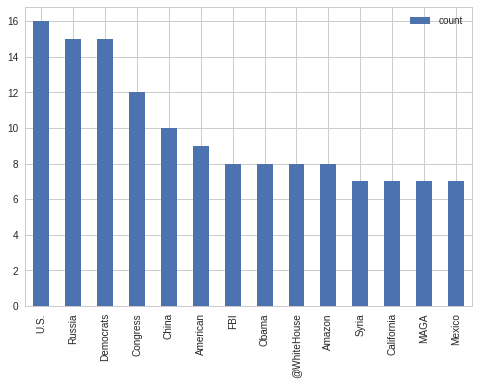

In [180]:
text = list(ents.keys())
labels = list(ents.values())
data = {'text':text,'label':labels}
df2 = pd.DataFrame(data)

for index,row in df2.iterrows():
    df2.at[index,'count'] = counts[row['text']]

#sort by count greater than 7
df2 = df2[df2['count'] >= 7]
df2 = df2.sort_values(by=['count'], ascending=False)
bar = df2.plot.bar()
bar.set_xticklabels(df2['text'], rotation=90)

Save the figure as an image and tweet it out.

In [116]:
barname = 'fig.png'
wordcloudname = 'wordcloud.png'
bar.get_figure().savefig(barname, bbox_inches='tight')
fig.savefig('wordcloud.png', bbox_inches='tight')
#api.update_with_media(filename, status='test')

### Sentiment of tweets on a scatterplot
[Individual tags for a scatterplot](https://stackoverflow.com/questions/5147112/how-to-put-individual-tags-for-a-scatter-plot)

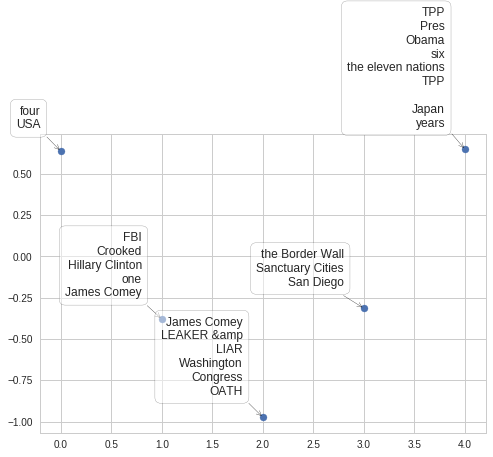

In [117]:
plt.scatter(range(len(sentiment)), sentiment)

for label, x, y in zip(entities, range(len(sentiment)), sentiment):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()

## Pie chart of approval rating

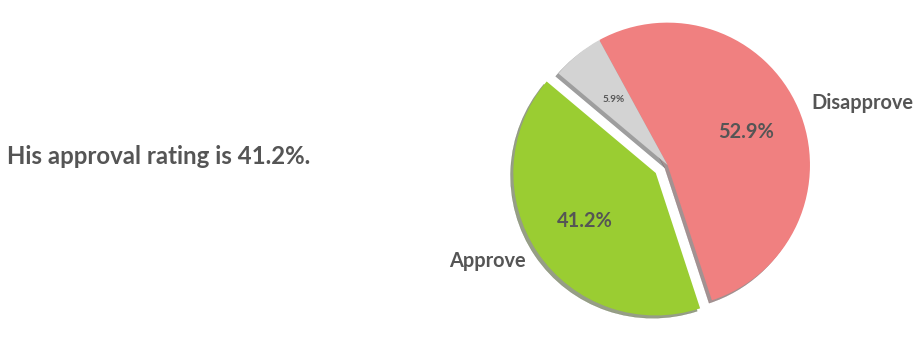

In [32]:
labels = 'Approve', 'Disapprove', ''
sizes = [current_approval, current_disapproval, 100-current_approval-current_disapproval]
colors = ['yellowgreen', 'lightcoral', 'lightgray']
explode = (0.1, 0, 0)  # explode 1st slice

patches, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.title(approval_str,x=-0.5,y=0.5,size=24)
texts[0].set_fontsize(20)
texts[1].set_fontsize(20)
texts[0].set_fontweight('bold')
texts[1].set_fontweight('bold')

autotexts[0].set_fontsize(20)
autotexts[1].set_fontsize(20)
autotexts[0].set_fontweight('bold')
autotexts[1].set_fontweight('bold')
autotexts[2].set_fontweight('bold')


plt.axis('equal')
fig = plt.gcf()
fig.set_size_inches(9,6)
plt.show()